### Contextual regression demo
In this repo, we train a simple contextual regression CNN model on synthetic sequence data, using
10,000 sequences of length 15, where all positions except two are random (those two are fixed).
The output y-value is preassigned to be a function of five specific positions. We show that
contextual regression misidentifies the least important of the five as the most important, and
further misidentifies fixed positions (positions that do not vary throughout the training set)
as more important than positions actually related to the outcome. It is easy to demonstrate
by changing the parameters and / or NN architecture in this file and ``simple_net.py`` that
the results of contextual regression are NN-architecture and hyperparameter dependent as well.

In [1]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from importlib import reload
import simple_net
reload(simple_net)

from simple_net import SimpleNet, train_helper, predict_helper, rep_helper

Now we generate synthetic data. Each sequence has three options at all 15 positions.

In [2]:
rng = np.random.default_rng(123)
selection = rng.choice(3, size=(10000, 15))
raw_x = np.zeros((10000, 15, 3))

#Positions 5 and 6 are fixed.
for i in range(selection.shape[0]):
    for j in range(selection.shape[1]):
        if j in [5,6]:
            continue
        raw_x[i,j,selection[i,j]] = 1

#Now we generate the y-values using a totally arbitrary relationship between the first 5 positions in
#the sequence. We also add a sprinkling of noise so the task isn't too easy.
raw_y = raw_x[:,0,0] * 0.1 + raw_x[:,1,1] * 1.1 - raw_x[:,2,0] * 0.5 + raw_x[:,3,2] * 0.26 - raw_x[:,4,1] * 0.01
raw_y += raw_x[:,0,2] * raw_x[:,1,0] * 0.3 + raw_x[:,1,2] * 0.45
raw_y -= raw_x[:,2,0] * raw_x[:,3,1] * 0.1

raw_y += rng.normal(scale=0.02, size=raw_y.shape[0])

#Positions 5 and 6 are fixed.
raw_x[:,5,0] = 1
raw_x[:,6,1] = 1

X_train = torch.from_numpy(raw_x[:8000,...])
Y_train = torch.from_numpy(raw_y[:8000])
X_val = torch.from_numpy(raw_x[8000:,...])
Y_val = torch.from_numpy(raw_y[8000:])

In [3]:
init_model = SimpleNet(rseed=123)

In [ ]:
0.9966576649754738

In [4]:
r2_train, r2_val = train_helper(init_model, X_train, Y_train, X_val, Y_val, n_epochs=100,
                               lr=1e-4, batch_size=100)

Epoch: 0
Epoch: 20
Epoch: 40
Epoch: 60
Epoch: 80


In [5]:
print(r2_val[-1])

0.9966576649754738


(0.5, 1.0)

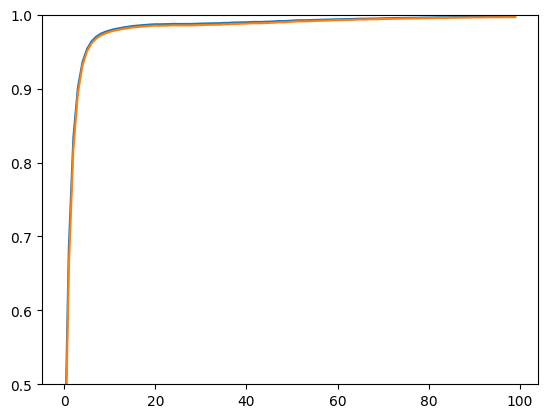

In [6]:
plt.plot(r2_train)
plt.plot(r2_val)
plt.ylim(0.5,1)

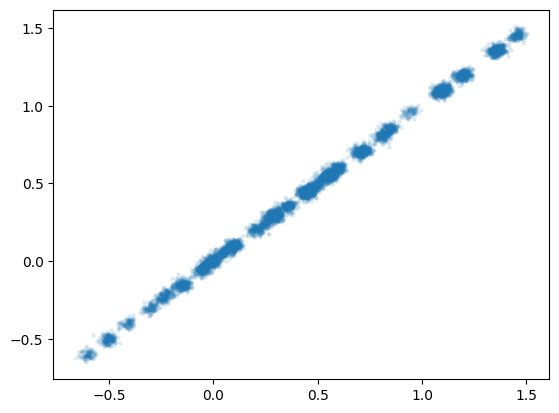

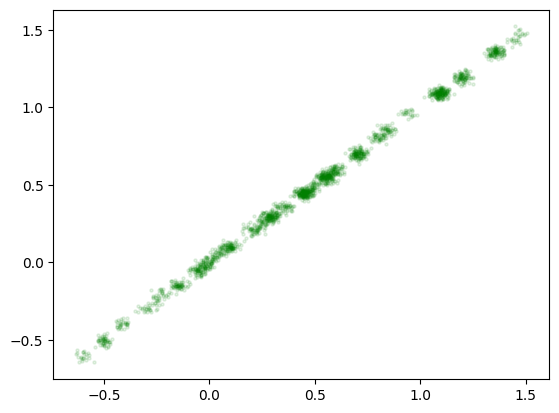

In [7]:
trainpreds = predict_helper(init_model, X_train)
valpreds = predict_helper(init_model, X_val)

plt.scatter(trainpreds, Y_train.numpy(), s=5, alpha=0.1)
plt.show()
plt.scatter(valpreds, Y_val.numpy(), s=5, color="green", alpha=0.1)
plt.show()

Now we'll generate contextual regression weights for all validation data.

In [8]:
val_reps = rep_helper(init_model, X_val)

We could try to assign position importance using the largest absolute value weight at any position
or using the sum of absolute value weights at any position. We'll try both...

In [9]:
pos_imp1 = np.abs(val_reps).max(axis=2)
pos_imp2 = np.sum(np.abs(val_reps), axis=2)

In [10]:
max_imps, sum_imps = [], []
max_labels, sum_labels = [], []

for i in range(15):
    max_imps.append(pos_imp1[:,i])
    sum_imps.append(pos_imp2[:,i])
    max_labels += [str(i) for j in range(pos_imp1.shape[0])]
    sum_labels += [str(i) for j in range(pos_imp2.shape[0])]

max_imps = np.concatenate(max_imps)
sum_imps = np.concatenate(sum_imps)

Notice two striking things about the charts below. Of the truly important positions -- the ones
we know are related to the outcome -- position 4 was the least important; it contributes only 0.01.
Yet it is misidentified as the most important position in the sequence. Also notice that position
6, which is fixed (never varies) is misidentified as being as important or more important than all
the remaining truly important positions. Finally, the noise positions 7-14 are misidentified as having
substantial importance when we know they are not related to the outcome.

You can change these results by adjusting the hyperparameters and the NN architectures, and you can
get many different versions of these plots -- which is another drawback. In practice we don't know 
in real-world situations which positions are important, and if a method can be used to generate many
different feature importance rankings, this may generate more confusion than it solves.

These results clearly demonstrate that 1) contextual regression may fail to identify the positions
that are actually important in a sequence and 2) it may given very different results depending on
setup.

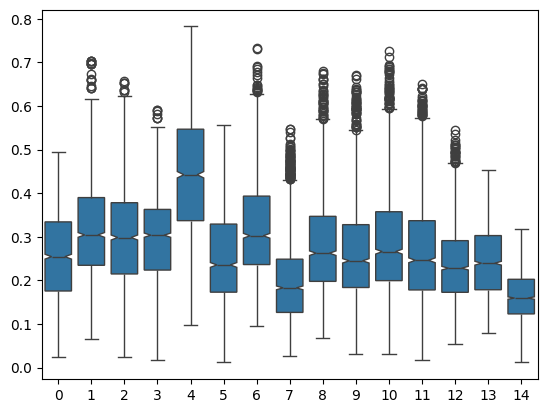

In [11]:
import seaborn as sns
sns.boxplot(y=max_imps, x=max_labels, notch=True)
plt.show()

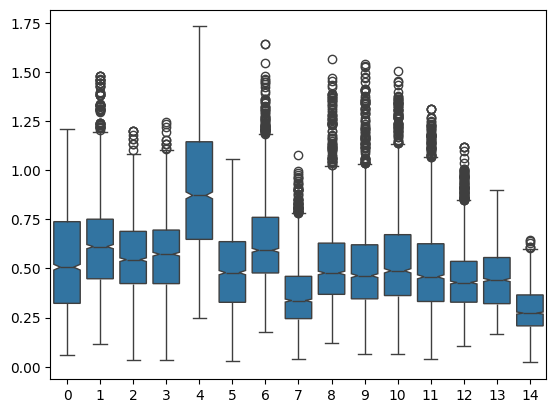

In [12]:
sns.boxplot(y=sum_imps, x=sum_labels, notch=True)
plt.show()